# 4.7 Design Deep Reinforcement Learning Agent
## Data Considerations 

In this notebook we will implement some of the considerations necessary to train this model on larger datasets in the scope of > gb. 

In order to do so, we will take the following steps:

1) Save datasets as TFDatasets   
2) Implement iteration on the TFDataset as most models prefer. This is important for distributed learning.   
3) Checkpoint and save models accordingly so they can be loaded again.  
4) Predict on evaluation data.  

#### Download datasets for all the stocks in the S&P 500.

In [2]:
from IPython import display
!pip install gcsfs
!pip install tf-agents[reverb]
display.clear_output()

In [3]:
from google.colab import drive
from google.cloud import storage
import pandas as pd
import time
import pandas as pd 
import matplotlib.pyplot as plt
from __future__ import absolute_import, division, print_function

import abc
import tensorflow as tf
import numpy as np
import base64
import IPython
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.experimental.train import actor
from tf_agents.experimental.train import learner
from tf_agents.experimental.train import triggers
from tf_agents.experimental.train.utils import spec_utils
from tf_agents.experimental.train.utils import strategy_utils
from tf_agents.experimental.train.utils import train_utils
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
import reverb

tf.compat.v1.enable_v2_behavior()

In [4]:
# drive.mount('/content/drive')

# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/content/drive/My Drive/fin-aml/fin-aml-gcskeys-337dfd8d8867.json"

# storage_client = storage.Client()
# display.clear_output()

In [5]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

tempdir = tempfile.gettempdir()

In [6]:
# df = pd.read_csv('gs://fin-datasets-aml/data/sp500/spdfm.csv')
# df.set_index('datetime', inplace=True)
# df.head()

In [7]:
# create toy data to test whether the model works
# 311 time steps of a sine wave, X = 0:310, y = 311
# linspace 0 311 as columns
# rows of different unique waves in A, B, C, D
# maybe something like 5000 rows to start with
import numpy as np
feature_space = np.linspace(0, 311, 311).reshape(1, 311)

A = np.random.normal(0, .1, size=5000).reshape(5000,1)
B = np.random.normal(0, .1, size=5000).reshape(5000, 1)
C = np.random.normal(0, 3, size=5000).reshape(5000, 1)
D = np.random.normal(0, 100, size=5000).reshape(5000, 1)


Xy = np.sin(np.matmul(C, feature_space)*(2*np.pi) - D) * A + B
# X = np.matmul(, A) + B
# X.shape
Xy.shape

(5000, 311)

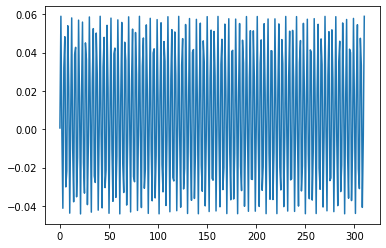

In [8]:
import matplotlib.pyplot as plt

plt.plot(Xy[3]);

In [9]:
import pandas as pd 

Xdf = pd.DataFrame(Xy)
Xdf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310
0,0.090452,0.100844,0.084061,0.090256,0.100917,0.084186,0.090061,0.100985,0.084313,0.089866,0.101050,0.084444,0.089672,0.101111,0.084578,0.089479,0.101168,0.084714,0.089287,0.101222,0.084854,0.089096,0.101271,0.084996,0.088905,0.101317,0.085141,0.088717,0.101359,0.085289,0.088529,0.101397,0.085439,0.088342,0.101431,0.085592,0.088157,0.101461,0.085747,0.087974,0.101487,0.085905,0.087792,0.101509,0.086065,0.087611,0.101527,0.086228,0.087433,0.101541,...,0.082436,0.093680,0.099157,0.082500,0.093486,0.099286,0.082568,0.093290,0.099411,0.082640,0.093095,0.099533,0.082715,0.092898,0.099652,0.082794,0.092701,0.099768,0.082876,0.092504,0.099880,0.082962,0.092306,0.099989,0.083052,0.092108,0.100095,0.083146,0.091910,0.100198,0.083242,0.091712,0.100297,0.083343,0.091514,0.100392,0.083446,0.091316,0.100484,0.083553,0.091118,0.100572,0.083664,0.090921,0.100657,0.083778,0.090724,0.100738,0.083895,0.090527
1,-0.111816,-0.115425,-0.155707,-0.079578,-0.176353,-0.078254,-0.158090,-0.112459,-0.114774,-0.156237,-0.079275,-0.176369,-0.078530,-0.157579,-0.113103,-0.114125,-0.156761,-0.078980,-0.176376,-0.078813,-0.157063,-0.113750,-0.113477,-0.157281,-0.078692,-0.176374,-0.079103,-0.156541,-0.114398,-0.112832,-0.157795,-0.078413,-0.176363,-0.079402,-0.156014,-0.115048,-0.112188,-0.158303,-0.078141,-0.176344,-0.079708,-0.155482,-0.115700,-0.111547,-0.158806,-0.077877,-0.176317,-0.080022,-0.154945,-0.116353,...,-0.171221,-0.073774,-0.171288,-0.093178,-0.136289,-0.136785,-0.092780,-0.171507,-0.073778,-0.170996,-0.093700,-0.135640,-0.137430,-0.092267,-0.171785,-0.073790,-0.170696,-0.094228,-0.134989,-0.138073,-0.091760,-0.172056,-0.073810,-0.170389,-0.094761,-0.134337,-0.138714,-0.091258,-0.172318,-0.073839,-0.170074,-0.095299,-0.133684,-0.139353,-0.090761,-0.172573,-0.073877,-0.169751,-0.095842,-0.133029,-0.139989,-0.090271,-0.172820,-0.073923,-0.169421,-0.096390,-0.132372,-0.140623,-0.089786,-0.173059
2,-0.129826,-0.107974,-0.102031,-0.131281,-0.100812,-0.109491,-0.129156,-0.095998,-0.117609,-0.123865,-0.094466,-0.124807,-0.116437,-0.096515,-0.129684,-0.108316,-0.101747,-0.131292,-0.101082,-0.109143,-0.129319,-0.096143,-0.117266,-0.124147,-0.094458,-0.124535,-0.116783,-0.096356,-0.129536,-0.108660,-0.101467,-0.131297,-0.101356,-0.108797,-0.129475,-0.096294,-0.116921,-0.124425,-0.094457,-0.124258,-0.117128,-0.096202,-0.129382,-0.109005,-0.101191,-0.131295,-0.101635,-0.108453,-0.129626,-0.096451,...,-0.128227,-0.095353,-0.119341,-0.122354,-0.094615,-0.126132,-0.114638,-0.097429,-0.130345,-0.106579,-0.103248,-0.131161,-0.099745,-0.110940,-0.128420,-0.095465,-0.119008,-0.122656,-0.094572,-0.125884,-0.114990,-0.097239,-0.130230,-0.106913,-0.102948,-0.131200,-0.099995,-0.110588,-0.128607,-0.095584,-0.118673,-0.122954,-0.094536,-0.125631,-0.115341,-0.097055,-0.130108,-0.107249,-0.102652,-0.131233,-0.100251,-0.110237,-0.128788,-0.095709,-0.118336,-0.123248,-0.094506,-0.125373,-0.115691,-0.096877
3,0.000682,0.058993,-0.002032,-0.041219,0.032086,0.048301,-0.030085,-0.021736,0.054034,0.021941,-0.043772,0.008913,0.058116,-0.009988,-0.037849,0.038986,0.042769,-0.035252,-0.014585,0.056959,0.013873,-0.044170,0.017106,0.055946,-0.017501,-0.033325,0.045081,0.036335,-0.039330,-0.006873,0.058621,0.005640,-0.043251,0.025051,0.052538,-0.024378,-0.027762,0.050215,0.029163,-0.042216,0.001204,0.058976,-0.002548,-0.041041,0.032546,0.047979,-0.030444,-0.021301,0.054257,0.021436,...,-0.043974,0.020182,0.054786,-0.020213,-0.031315,0.047163,0.033672,-0.040578,-0.003819,0.058912,0.002495,-0.042557,0.027978,0.050926,-0.026800,-0.025391,0.051894,0.026266,-0.042988,0.004342,0.058764,-0.005620,-0.039866,0.035250,0.045957,-0.032515,-0.018630,0.0

In [18]:
X = np.array(Xy[:, :310], dtype=np.float32)
y = np.array(Xy[:, 310], dtype=np.float32)
X.shape, y.shape

((5000, 310), (5000,))

#### Transform the numpy array into TF Dataset 

In [14]:
tf.data.Dataset.from_tensor_slices((X, y))

<TensorSliceDataset shapes: ((310,), ()), types: (tf.float32, tf.float32)>

In [15]:
Xy_dataset = tf.data.Dataset.from_tensor_slices((X, y))

In [16]:
for a,b in Xy_dataset.take(1):
  print(a)
  print(b)

tf.Tensor(
[0.0904524  0.10084422 0.08406127 0.09025635 0.10091659 0.0841858
 0.0900609  0.10098522 0.08431341 0.08986615 0.10105009 0.08444406
 0.08967216 0.10111116 0.08457769 0.08947902 0.10116841 0.08471423
 0.08928681 0.10122183 0.08485366 0.08909561 0.10127138 0.08499589
 0.08890548 0.10131705 0.08514088 0.08871651 0.10135882 0.08528856
 0.08852879 0.10139667 0.08543888 0.08834238 0.10143059 0.08559177
 0.08815736 0.10146056 0.08574717 0.0879738  0.10148657 0.08590502
 0.08779178 0.10150861 0.08606526 0.08761137 0.10152667 0.08622781
 0.08743266 0.10154074 0.08639262 0.0872557  0.10155082 0.08655961
 0.08708058 0.10155691 0.08672871 0.08690736 0.101559   0.08689988
 0.08673612 0.10155708 0.08707301 0.08656693 0.10155118 0.08724805
 0.08639984 0.10154127 0.08742493 0.08623493 0.10152736 0.08760356
 0.08607228 0.10150947 0.0877839  0.08591194 0.10148761 0.08796585
 0.08575399 0.10146178 0.08814934 0.08559848 0.10143197 0.0883343
 0.08544548 0.10139823 0.08852065 0.08529504 0.101360

In [21]:
def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [22]:
def serialize_example(x,y):
  """
  Creates a tf.train.Example message ready to be written to a file.
  """
  # Create a dictionary mapping the feature name to the tf.train.Example-compatible
  # data type.
  feature = {
      'x': _float_feature(x),
      'y': _float_feature(y)
  }

  # Create a Features message using tf.train.Example.

  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

In [23]:
def tf_serialize_example(x,y):
  tf_string = tf.py_function(
    serialize_example,
    (x,y),  # pass these args to the above function.
    tf.string)      # the return type is `tf.string`.
    
  return tf.reshape(tf_string, ()) # The result is a scalar

In [24]:
tf_serialize_example(a,b)

InvalidArgumentError: ignored

In [ ]:
def generator():
  for features in features_dataset:
    yield serialize_example(*features)

#### Build an environment to represent this movement

In [10]:
X[0].shape

(310,)

In [11]:
class StockMarketEnv(py_environment.PyEnvironment):
    '''
    Observation: The observation should be a (90,505) matrix
    Action: A (505) vector with probabilties from 0 1, max 10 are encoded as 1, all others are 0
    Reward: dot product of the (505,1) top 10 choices with the next (1,505) returns
    '''
    def __init__(self, X, y):
        self._action_spec = array_spec.BoundedArraySpec(
                                    shape=(1,), dtype=np.float32, minimum=0, maximum=1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
                                    shape=(310,), dtype=np.float32, minimum=-1, maximum=1 ,name='observation')
        self._X = X
        self._y = y
        self._i = 0
        self._state = np.array(self._X[self._i], dtype=np.float32)
        self._episode_ended = False

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._i = 0
        self._state = np.array(self._X[self._i], dtype=np.float32) ## input array
        self._episode_ended = False
        return ts.restart(self._state)

    def _step(self, action):
        if self._episode_ended:
            return self.reset()

        self._i += 1

        if self._i + 1 >= self._y.shape[0]:
            self._episode_ended = True
        
        reward_state = np.array(self._y[self._i], dtype=np.float32)
        reward = -(action[0] - reward_state)**2
        
        self._state = np.array(self._X[self._i], dtype=np.float32)
        
        if self._episode_ended:
            return ts.termination(np.array(self._state, dtype=np.float32), reward=np.array(reward, dtype=np.float32))
        else:
            return ts.transition(np.array(self._state, dtype=np.float32), reward=np.array(reward, dtype=np.float32), discount=1.0)

In [12]:
environment = StockMarketEnv(X, y)
utils.validate_py_environment(environment, episodes=5)

##### Train a DQN to learn on it

In [13]:
# Important interval values for training speed
# Set lower to increase speed of training 

num_iterations = 10 # @param {type:"integer"}
log_interval = 100 # @param {type:"integer"}=
num_eval_episodes = 1 # @param {type:"integer"}
eval_interval = 1 # @param {type:"integer"}

In [14]:
initial_collect_steps = 10000 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 10000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}

actor_fc_layer_params = (310,)
critic_joint_fc_layer_params = (310,)



policy_save_interval = 5000 # @param {type:"integer"}

In [15]:
X.shape[0], X.shape[0]//2

(5000, 2500)

In [16]:
y.shape[0],  y.shape[0]//2

(5000, 2500)

In [17]:
# Code to produce tf environments
# train_py_env = StockMarketEnv(X[:X.shape[0]//2])
# eval_py_env = StockMarketEnv(X[X.shape[0]//2:])
# train_env = tf_py_environment.TFPyEnvironment(train_py_env)
# eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Code to produce py environments 
train_env = StockMarketEnv(X[:X.shape[0]//2], y[:y.shape[0]//2])
eval_env = StockMarketEnv(X[X.shape[0]//2:], y[y.shape[0]//2:])

In [18]:
train_env._y, eval_env._y

(array([ 0.02279128, -0.04242661,  0.08742822, ..., -0.22473535,
        -0.00361564, -0.16828975], dtype=float32),
 array([-0.06380255, -0.00887402, -0.1040407 , ...,  0.01091622,
        -0.07825399,  0.1870721 ], dtype=float32))

In [19]:
print('Observation Spec:')
print(train_env.time_step_spec().observation)
print('Action Spec:')
print(train_env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(310,), dtype=dtype('float32'), name='observation', minimum=-1.0, maximum=1.0)
Action Spec:
BoundedArraySpec(shape=(1,), dtype=dtype('float32'), name='action', minimum=0.0, maximum=1.0)


In [20]:
use_gpu = False 

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

In [21]:
observation_spec, action_spec, time_step_spec = (spec_utils.get_tensor_specs(train_env))

with strategy.scope():
    critic_net = critic_network.CriticNetwork((observation_spec, action_spec),
                                            observation_fc_layer_params=None,
                                            action_fc_layer_params=None,
                                            joint_fc_layer_params=critic_joint_fc_layer_params,
                                            kernel_initializer='glorot_uniform',
                                            last_kernel_initializer='glorot_uniform')

In [22]:
action_spec

BoundedTensorSpec(shape=(1,), dtype=tf.float32, name='action', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))

In [23]:
observation_spec

BoundedTensorSpec(shape=(310,), dtype=tf.float32, name='observation', minimum=array(-1., dtype=float32), maximum=array(1., dtype=float32))

In [24]:
actor_fc_layer_params

(310,)

In [25]:
with strategy.scope():
    actor_net = actor_distribution_network.ActorDistributionNetwork(observation_spec,
                                                                    action_spec,
                                                                    fc_layer_params=actor_fc_layer_params,
                                                                    continuous_projection_net=(
                                              tanh_normal_projection_network.TanhNormalProjectionNetwork))

In [26]:
time_step_spec

TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(310,), dtype=tf.float32, name='observation', minimum=array(-1., dtype=float32), maximum=array(1., dtype=float32)))

In [27]:
with strategy.scope():
    train_step = train_utils.create_train_step()

    tf_agent = sac_agent.SacAgent(
                                time_step_spec,
                                action_spec,
                                actor_network=actor_net,
                                critic_network=critic_net,
                                actor_optimizer=tf.compat.v1.train.AdamOptimizer(
                                                                learning_rate=actor_learning_rate),
                                critic_optimizer=tf.compat.v1.train.AdamOptimizer(
                                                                learning_rate=critic_learning_rate),
                                alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
                                                                learning_rate=alpha_learning_rate),
                                target_update_tau=target_update_tau,
                                target_update_period=target_update_period,
                                td_errors_loss_fn=tf.math.squared_difference,
                                gamma=gamma,
                                reward_scale_factor=reward_scale_factor,
                                train_step_counter=train_step)

    tf_agent.initialize()

In [28]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

In [29]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

In [30]:
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

In [31]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

In [32]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

In [33]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

In [34]:
random_policy = random_py_policy.RandomPyPolicy(
  train_env.time_step_spec(), train_env.action_spec())

In [35]:
initial_collect_actor = actor.Actor(
              train_env,
              random_policy,
              train_step,
              steps_per_run=initial_collect_steps,
              observers=[rb_observer])
initial_collect_actor.run()

In [36]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
                  train_env,
                  collect_policy,
                  train_step,
                  steps_per_run=1,
                  metrics=actor.collect_metrics(10),
                  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
                  observers=[rb_observer, env_step_metric])

In [37]:
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

In [38]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


In [39]:
%%time
def get_eval_metrics():
    eval_actor.run()
    results = {}
    for metric in eval_actor.metrics:
        results[metric.name] = metric.result()
    return results

metrics = get_eval_metrics()

CPU times: user 3.45 s, sys: 275 ms, total: 3.72 s
Wall time: 3.29 s


In [40]:
eval_env._y

array([-0.06380255, -0.00887402, -0.1040407 , ...,  0.01091622,
       -0.07825399,  0.1870721 ], dtype=float32)

In [41]:
%%time
def log_eval_metrics(step, metrics):
    eval_results = (', ').join(
              '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
    print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = -843.354919, AverageEpisodeLength = 2499.000000
CPU times: user 462 µs, sys: 0 ns, total: 462 µs
Wall time: 471 µs


In [42]:
training_params = [num_iterations,
                    log_interval,
                    num_eval_episodes,
                    eval_interval]
          
print(training_params)

[10, 100, 1, 1]


In [43]:
#@test {"skip": true}
try:
    %%time
except:
    pass

start = time.time()
# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = metrics["AverageReturn"]
returns = [avg_return]

for _ in range(num_iterations):
    # Training.
    collect_actor.run()
    loss_info = agent_learner.run(iterations=1)

    # Evaluating.
    step = agent_learner.train_step_numpy

    if eval_interval and step % eval_interval == 0:
        metrics = get_eval_metrics()
        log_eval_metrics(step, metrics)
        returns.append(metrics["AverageReturn"])

    if log_interval and step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))
        minsec = divmod((time.time() - start), 60)
        hourmin = divmod(minsec[0], 60)
        print(f"Time elasped: {int(hourmin[0])}:{int(hourmin[1])}:{minsec[1]}")

rb_observer.close()
reverb_server.stop()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
step = 1: AverageReturn = -841.190735, AverageEpisodeLength = 2499.000000
step = 2: AverageReturn = -858.180542, AverageEpisodeLength = 2499.000000
step = 3: AverageReturn = -866.887695, AverageEpisodeLength = 2499.000000
step = 4: AverageReturn = -883.350037, AverageEpisodeLength = 2499.000000
step = 5: AverageReturn = -880.205139, AverageEpisodeLength = 2499.000000
step = 6: AverageReturn = -908.121765, AverageEpisodeLength = 2499.000000
step = 7: AverageReturn = -864.832520, AverageEpisodeLength = 2499.000000
step = 8: AverageReturn = -870.467529, AverageEpisodeLength = 2499.000000
step = 9: AverageReturn = -873.192322, AverageEpisodeLength = 2499.000000
step = 10: AverageReturn = -837.118347, AverageEpisodeLength = 2499.000000


(-911.6719360351562, -833.5681762695312)

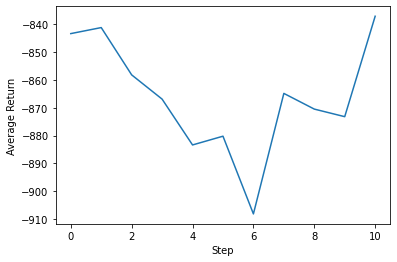

In [46]:
#@test {"skip": true}

steps = range(0, 11, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()

In [47]:
for metric in collect_actor.metrics:
  print(f"{metric.name} = {metric.result()}")

NumberOfEpisodes = 0
EnvironmentSteps = 10
AverageReturn = 0.0
AverageEpisodeLength = 0.0


In [48]:
collect_actor.metrics[2].result()

array(0., dtype=float32)